In [25]:
from MagicCube import MagicCube
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [26]:
class GeneticAlgorithm:
    def __init__(self, cube_size, population_size=50, max_generations=1000, mutation_rate=0.05, elitism_count=2):
        self.cube_size = cube_size
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_count = elitism_count
        self.population = self.initialize_population()

    def initialize_population(self):
        return [MagicCube(self.cube_size) for _ in range(self.population_size)]

    def fitness(self, cube):
        return cube.objective_function()

    def calculate_cumulative_probabilities(self):
        fitness_values = np.array([self.fitness(cube) for cube in self.population])
        fitness_sum = np.sum(1 / fitness_values)
        probabilities = (1 / fitness_values) / fitness_sum
        return np.cumsum(probabilities)

    def roulette_wheel_selection(self):
        cumulative_probabilities = self.calculate_cumulative_probabilities()
        rand = random.random()
        for i, prob in enumerate(cumulative_probabilities):
            if rand <= prob:
                return self.population[i]
        return self.population[-1]

    def crossover(self, parent1, parent2):
        parent1_1d = parent1.cube.flatten()
        parent2_1d = parent2.cube.flatten()
        
        # Perform two-point crossover
        crossover_points = sorted(random.sample(range(len(parent1_1d)), 2))
        offspring_1d = np.concatenate([
            parent1_1d[:crossover_points[0]], 
            parent2_1d[crossover_points[0]:crossover_points[1]], 
            parent1_1d[crossover_points[1]:]
        ])

        offspring_cube = offspring_1d.reshape((self.cube_size, self.cube_size, self.cube_size))
        offspring = MagicCube(self.cube_size)
        offspring.cube = offspring_cube
        return offspring

    def mutate(self, cube):
        cube_1d = cube.cube.flatten()
        full_set = set(range(1, self.cube_size ** 3 + 1))
        current_numbers = set(cube_1d)
        missing_numbers = list(full_set - current_numbers)
        duplicates = [num for num in current_numbers if np.count_nonzero(cube_1d == num) > 1]

        random.shuffle(missing_numbers)
        for duplicate in duplicates:
            if missing_numbers:
                for i, val in enumerate(cube_1d):
                    if val == duplicate:
                        cube_1d[i] = missing_numbers.pop()
                        break

        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(cube_1d)), 2)
            cube_1d[idx1], cube_1d[idx2] = cube_1d[idx2], cube_1d[idx1]

        cube.cube = cube_1d.reshape((self.cube_size, self.cube_size, self.cube_size))

    def evolve(self):
        generation = 0
        best_solution = None
        best_fitness = float('inf')
        fitness_history_max = []
        fitness_history_avg = []

        start_time = time.time()

        while generation < self.max_generations:
            new_population = []

            # Apply elitism: carry forward best solutions
            sorted_population = sorted(self.population, key=self.fitness)
            new_population.extend(sorted_population[:self.elitism_count])

            # Adjust mutation rate adaptively based on generation count
            adaptive_mutation_rate = max(self.mutation_rate * (1 - generation / self.max_generations), 0.01)

            # Generate new offspring with roulette wheel selection
            while len(new_population) < self.population_size:
                parent1 = self.roulette_wheel_selection()
                parent2 = self.roulette_wheel_selection()

                offspring = self.crossover(parent1, parent2)
                self.mutate(offspring)

                new_population.append(offspring)

            self.population = new_population

            # Evaluate the best solution in the current population
            best_fitness_gen = min(self.fitness(cube) for cube in self.population)
            avg_fitness_gen = np.mean([self.fitness(cube) for cube in self.population])

            fitness_history_max.append(best_fitness_gen)
            fitness_history_avg.append(avg_fitness_gen)

            # Track the best solution
            if best_fitness_gen < best_fitness:
                best_fitness = best_fitness_gen
                best_solution = min(self.population, key=self.fitness)

            # Early stopping if the optimal solution is found
            if best_fitness == 0:
                break

            generation += 1

        end_time = time.time()
        print(f"Final Status: {best_fitness}")
        duration = end_time - start_time

        return best_solution, fitness_history_max, fitness_history_avg, generation, duration

In [27]:
def visualize_experiment(initial_cube, final_cube, fitness_history_max, fitness_history_avg, population_size, max_generations, duration):
    print("Initial State:")
    initial_cube.visualize()

    print("Final State:")
    final_cube.visualize()

    plt.plot(range(len(fitness_history_max)), fitness_history_max, color='red', label="Max Fitness")
    plt.plot(range(len(fitness_history_avg)), fitness_history_avg, color='blue', label="Avg Fitness")
    plt.title(f'Objective Function vs Generations (Pop: {population_size}, Iter: {max_generations})')
    plt.xlabel('Generations')
    plt.ylabel('Objective Function (f(x))')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Population Size: {population_size}")
    print(f"Generations: {max_generations}")
    print(f"Duration: {duration:.2f} seconds")

Run 1 with Population Size: 25 and Max Generations: 50
Final Status: 7505
Total Generations: 50
Duration: 30.79 seconds
Initial State:


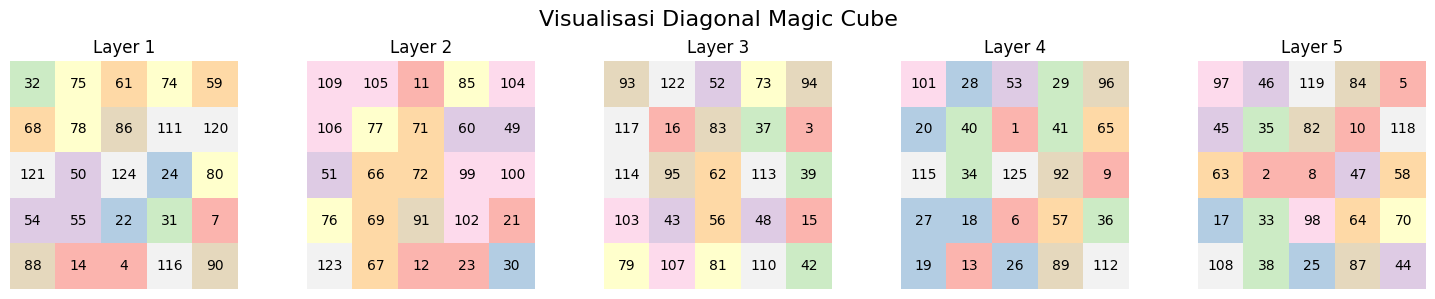

Final State:


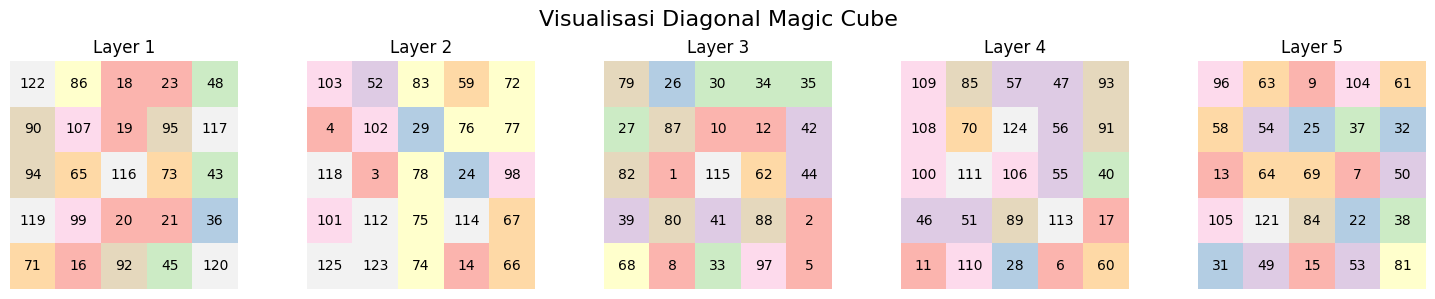

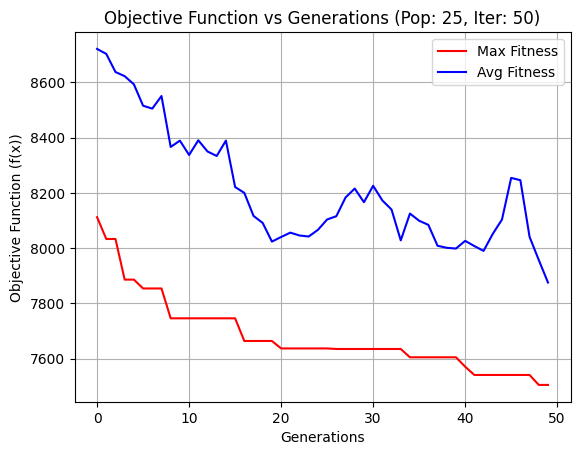

Population Size: 25
Generations: 50
Duration: 30.79 seconds


In [28]:
if __name__ == "__main__":
    # Set population size and max generations manually here
    population_size = 25  # Example population size
    max_generations = 50  # Example max generations

    # Run the genetic algorithm for multiple iterations
    for i in range(1):
        print(f"Run {i+1} with Population Size: {population_size} and Max Generations: {max_generations}")
        initial_cube = MagicCube(n=5)
        ga = GeneticAlgorithm(cube_size=5, population_size=population_size, max_generations=max_generations)
        final_cube, fitness_history_max, fitness_history_avg, generations, duration = ga.evolve()
        
        print(f"Total Generations: {generations}")
        print(f"Duration: {duration:.2f} seconds")
        visualize_experiment(initial_cube, final_cube, fitness_history_max, fitness_history_avg, population_size, max_generations, duration)